### Import Libraries and Data

In [79]:
import re
import nltk
import string
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [88]:
# import training data
trainPath = '.\Data\\train.csv'
train = pd.read_csv(trainPath)
print('training shape: ', train.shape)
display(train.head())

# import test data
testPath = '.\Data\\test.csv'
test = pd.read_csv(testPath)
print('testing shape: ', test.shape)
display(test.head())

training shape:  (404290, 6)


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


testing shape:  (2345796, 3)


,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


### Visualize Training Set Classes

0    255027
1    149263
Name: is_duplicate, dtype: int64

0    63.080215
1    36.919785
Name: is_duplicate, dtype: float64


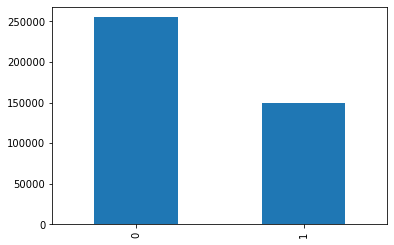

In [89]:
# number of classes
print(train["is_duplicate"].value_counts()); print() # count
print((train["is_duplicate"].value_counts()/train["is_duplicate"].count())*100) # percent

# plot 
train["is_duplicate"].value_counts().plot(kind="bar");

### Cleaning

In [90]:
# drop nan values
train = train.dropna()

# number of nan values after cleaning
print('number of null values: \n', train.isnull().sum())

number of null values: 
 id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64


In [91]:
# number of duplicate values
train.duplicated().sum()

0

### Undersampling Due To Class Imbalance

Counter({0: 255024, 1: 149263})
Counter({0: 149263, 1: 149263})


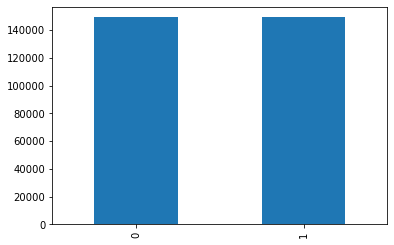

In [92]:
# random undersampling to fix class imbalance

from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

# summarize class distribution
print(Counter(train['is_duplicate']))

# define undersample strategy
undersample = RandomUnderSampler(sampling_strategy='majority', random_state=42)

# fit and apply the transform
# X_train, y_train = undersample.fit_resample(X_train, y_train)
train, _ = undersample.fit_resample(train, train['is_duplicate'])

# summarize class distribution
print(Counter(train['is_duplicate']))

# plot
train['is_duplicate'].value_counts().plot(kind="bar");

In [93]:
# downsample for compute purposes
train = train.sample(50000, random_state=42)
print(Counter(train['is_duplicate']))

Counter({1: 25034, 0: 24966})


### Clean Question Text

In [94]:
def clean_question(question):
    
    # remove punctuation
    question = "".join([char for char in question if char not in string.punctuation])
    
    # remove stopwords
    stopword = nltk.corpus.stopwords.words('english')
    question = " ".join([word for word in re.split('\W+', question) if word not in stopword])
    
    # lowercase
    question = question.lower()
    
    # stemming
    ps = nltk.PorterStemmer()
    question = " ".join([ps.stem(word) for word in re.split('\W+', question)])

    return question

In [96]:
# clean question1 and update dataframe
for idx, question in enumerate(train['question1']):
    train['question1'].iloc[idx] = clean_question(question)
    
# clean question2 and update dataframe
for idx, question in enumerate(train['question2']):
    train['question2'].iloc[idx] = clean_question(question)

C:\Users\ta1031742\AppData\Roaming\Python\Python38\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


### Count and TFIDF Vectorization - DONE 

In [102]:
# concate questions for vectorization
questions = list(train['question1']) + list(train['question2'])
print('number of questions: ', len(questions))

number of questions:  100000


In [103]:
# initialize vectorizer

# vec = TfidfVectorizer(max_features=3000)
vec = CountVectorizer(max_features=3000)

# fit transform data, split
vec = vec.fit_transform(questions)

# split
q1, q2 = np.vsplit(vec.toarray(),2)
print('q1 shape: ', q1.shape)
print('q2 shape: ', q2.shape)

q1 shape:  (50000, 3000)
q2 shape:  (50000, 3000)


In [104]:
# concatenate along column axis
all_qs = np.concatenate((q1,q2), axis=1)

# turn to dataframe
X_train = pd.DataFrame(all_qs)
y_train = train['is_duplicate']

# print shapes
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)

X_train shape:  (50000, 6000)
y_train shape:  (50000,)


In [105]:
# save data
with open('train_countvec.pickle', 'wb') as handle:
    pickle.dump([X_train, y_train], handle, protocol=pickle.HIGHEST_PROTOCOL)

### GloVe Word Embeddings - TO BE COMPLETED 8/3/22

In [83]:
# proprocess questions
questions = list(train['question1']) + list(train['question2'])
y_train = train['is_duplicate']

# fit tokenizer to training questions
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(questions)

# create the word_index dictionary using the tokenizer  
word_index = tokenizer.word_index

# find the vocabulary of training questions
vocabulary = list(word_index.keys())
print('vocabulary length: ', len(vocabulary))

# convert questions into sequences
sequences_train = tokenizer.texts_to_sequences(questions)

# pad sequences so all have same length
sequences_train = pad_sequences(sequences_train, maxlen=60)

vocabulary shape:  33222


In [86]:
# split 
q1, q2 = np.vsplit(sequences_train,2)

# concat
all_qs = np.concatenate((q1,q2), axis=1)
X_train = pd.DataFrame(all_qs)

In [81]:
# load glove dictionary
glove_dictionary = {}
with open('glove.6B.200d.txt', encoding="utf8") as file:
    for each_line in file:
        words_in_line, coeff_cients = each_line.split(maxsplit=1)
        coeff_cients = np.array(coeff_cients.split(),dtype = float)
        glove_dictionary[words_in_line] = coeff_cients

58

In [ ]:
# create embedding matrix
embedding_matrix = np.zeros((len(vocabulary), 60)) # maybe change to 120

# loop through all vocab words
for idx, word in enumerate(vocabulary):
    if word in list(glove_dictionary.keys()):
        embedding_matrix[idx:] = glove_dictionary[word]

In [ ]:
# save sequences_train (X), y_train, embedding matrix

In [ ]:
# will it be problematic that X_train is shape: (50000, 120)
# while embedding matrix is shape: (33222, 60)
# read this: https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/